In [1]:
import sys, os, math, json, time

sys.path.append(os.path.abspath("/home/imglab/Sasha/DeepLense/grav_lens_diff"))

from pathlib import Path
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from dataloaders import *
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("/home/imglab/Sasha/DeepLense/grav_lens_diff/Baseline_models/SwinIR"))
from models.network_swinir import SwinIR

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Python: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA RTX A5000


/home/imglab/.conda/envs/torchtest/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# lr_path = "/home/imglab/Sasha/DeepLense/grav_lens_diff/lr_all_lsst_20k.npy"
# hr_path = "/home/imglab/Sasha/DeepLense/grav_lens_diff/hr_all_lsst_20k.npy"

# LR = np.load(lr_path)   # [N,H,W]
# HR = np.load(hr_path)   # [N,H,W]
# assert LR.shape == HR.shape, f"Mismatch: {LR.shape} vs {HR.shape}"
# print("Loaded:", LR.shape)

# def compute_global_scale(hr, hi_pct=99.5):
#     vmax = np.percentile(hr.reshape(-1).astype(np.float64), hi_pct)
#     return float(vmax)

# scale = compute_global_scale(LR, 99.99)
# print("Global scale (p99.5 of HR):", scale)

# def to_unit(arr, scale):
#     x = torch.tensor(arr, dtype=torch.float32)
#     # x = x / (scale + 1e-8)
#     x = torch.clamp(x / (scale + 1e-8), 0.0, 1.0)
#     return x

# LR_t = to_unit(LR, scale).unsqueeze(1)   # [N,1,H,W]
# HR_t = to_unit(HR, scale).unsqueeze(1)   # [N,1,H,W]



In [ ]:
# vit_ds_train = PairsDatasetUnified(
#     root_dir=".",
#     norm_preset="hybrid",         # keep identical LR stats to diffusion
#     percentile_p=99.99, percentile_from="lr",
#     out_range="[0,1]",
#     pad_to=None,                    # or None if your model wants native size               # RGB repeat for ViT/SwinIR
#     noise_aug=noise_aug,          # SAME augment -> identical noisy LR per index
#     return_order="LRHR"
# )
# # Use the same split indices as above to keep train/val identical:
# idxs = torch.randperm(len(vit_ds_train), generator=torch.Generator().manual_seed(42))
# n_total = len(vit_ds_train)
# n_train = int(0.9 * n_total)
# vit_train = torch.utils.data.Subset(vit_ds_train, idxs[:n_train])
# vit_val   = torch.utils.data.Subset(vit_ds_train, idxs[n_train:])

# train_loader_swin = DataLoader(vit_train, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
# val_loader_swin   = DataLoader(vit_val,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [2]:
vit_train = PairsDatasetUnified(
    root_dir="../",
    lr_name = "HST-HSC_dataset/train_LR.npy",
    hr_name = "HST-HSC_dataset/train_HR.npy",
    resize_to=64, 
    norm_preset="minmax",         # keep identical LR stats to diffusion
    out_range="[0,1]",
    pad_to=None,                    # or None if your model wants native size               # RGB repeat for ViT/SwinIR
    noise_aug=None,          # SAME augment -> identical noisy LR per index
    return_order="LRHR"
)


vit_val = PairsDatasetUnified(
    root_dir="../",
    lr_name = "HST-HSC_dataset/test_LR.npy",
    hr_name = "HST-HSC_dataset/test_HR.npy",
    resize_to=64, 
    norm_preset="minmax",         # keep identical LR stats to diffusion
    out_range="[0,1]",
    pad_to=None,                    # or None if your model wants native size               # RGB repeat for ViT/SwinIR
    noise_aug=None,          # SAME augment -> identical noisy LR per index
    return_order="LRHR"
)



train_loader_swin = DataLoader(vit_train, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader_swin   = DataLoader(vit_val,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


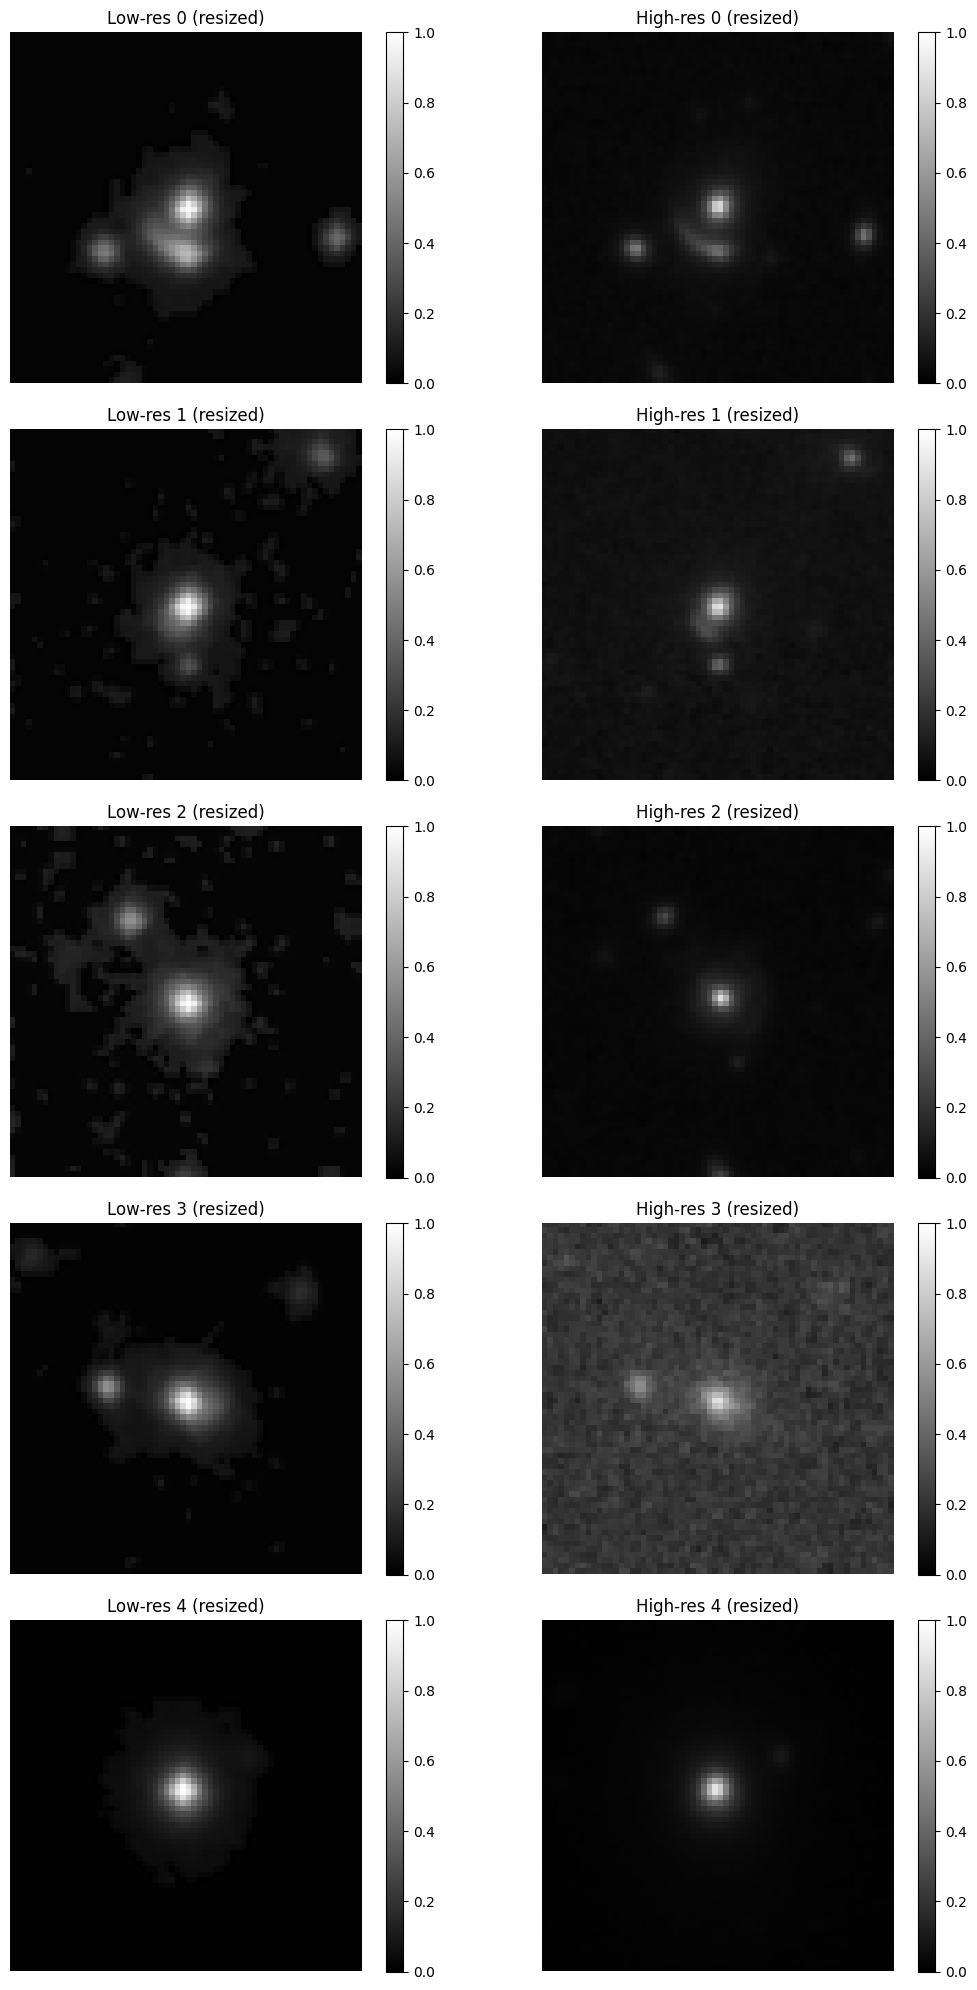

In [3]:
# Number of samples to display
num_samples = 5
# target_size = (128, 128)   
target_size = (64, 64)   

# Create a figure
fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 4))

for i in range(num_samples):
    lr, hr = vit_train[i]   # tensors, shape (1,H,W)

    # Interpolate both to target_size
    lr_up = F.interpolate(lr.unsqueeze(0), size=target_size, mode="bilinear", align_corners=False).squeeze().numpy()
    hr_up = F.interpolate(hr.unsqueeze(0), size=target_size, mode="bilinear", align_corners=False).squeeze().numpy()

    # Plot low-res (condition)
    im1 = axs[i, 0].imshow(lr_up, cmap='gray', vmin=0, vmax=1)
    axs[i, 0].set_title(f"Low-res {i} (resized)")
    axs[i, 0].axis('off')
    plt.colorbar(im1, ax=axs[i,0], fraction=0.046, pad=0.04)

    # Plot high-res (target)
    im2 = axs[i, 1].imshow(hr_up, cmap='gray', vmin=0, vmax=1)
    axs[i, 1].set_title(f"High-res {i} (resized)")
    axs[i, 1].axis('off')
    plt.colorbar(im2, ax=axs[i,1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:


# def show_samples(LR_t, HR_t, n=5, vmax_lr=None, vmax_hr=None):
#     """Plot n random LR–HR pairs after preprocessing."""
#     idxs = torch.randint(0, LR_t.size(0), (n,))
#     fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))

#     for i, idx in enumerate(idxs):
#         lr_img = LR_t[idx,0].cpu().numpy()
#         hr_img = HR_t[idx,0].cpu().numpy()

#         ax1, ax2 = axes[i]
#         im1 = ax1.imshow(lr_img, cmap="viridis", vmin=0, vmax=vmax_lr)
#         ax1.set_title("Low-res (preprocessed)")
#         plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

#         im2 = ax2.imshow(hr_img, cmap="viridis", vmin=0, vmax=vmax_hr)
#         ax2.set_title("High-res (preprocessed)")
#         plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

#         for a in (ax1, ax2):
#             a.axis("off")

#     plt.tight_layout()
#     plt.show()

# # Example usage:
# show_samples(LR_t, HR_t, n=4)


In [6]:
# N = LR_t.size(0)
# n_train = int(0.9 * N)

# train_ds = TensorDataset(LR_t[:n_train], HR_t[:n_train])
# val_ds   = TensorDataset(LR_t[n_train:], HR_t[n_train:])

# train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
# print("Train/Val:", len(train_ds), len(val_ds))

In [4]:
def build_swinir(scale=1, in_chans=1, img_size=48, window_size=8):
    return SwinIR(
        img_size=img_size,
        patch_size=1,
        in_chans=in_chans,
        embed_dim=96,                 # stronger than 60
        depths=[6, 6, 6, 6],
        num_heads=[6, 6, 6, 6],
        window_size=window_size,
        mlp_ratio=2.0,
        upsampler='',                 # no upscaler (same size)
        resi_connection='1conv',
        upscale=scale
    )

model = build_swinir(scale=1, in_chans=1, img_size=64, window_size=8).to(device)
sum(p.numel() for p in model.parameters())/1e6

/home/imglab/.conda/envs/torchtest/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


2.244625

In [5]:
def pad_to_window(x, window_size=8):
    B, C, H, W = x.shape
    ph = (window_size - H % window_size) % window_size
    pw = (window_size - W % window_size) % window_size
    if ph or pw:
        x = F.pad(x, (0, pw, 0, ph), mode='reflect')
    return x, H, W

def unpad_from_window(x, H, W):
    return x[:, :, :H, :W]

def forward_swinir(model, x, window_size=8):
    x_pad, H, W = pad_to_window(x, window_size)
    y_pad = model(x_pad)
    y = unpad_from_window(y_pad, H, W)
    return y


In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9, 0.99), weight_decay=1e-4)
epochs = 200
warmup_epochs = 5

def lr_lambda(ep):
    if ep < warmup_epochs:
        return (ep + 1) / warmup_epochs
    t = (ep - warmup_epochs) / max(1, (epochs - warmup_epochs))
    return 0.5 * (1 + math.cos(math.pi * t))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
criterion = nn.L1Loss()
grad_clip = 1.0

# --- EMA that only tracks trainable floating parameters ---
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        # only keep params that require grad AND are floating point
        self.shadow = {
            name: p.detach().clone()
            for name, p in model.named_parameters()
            if p.requires_grad and torch.is_floating_point(p)
        }

    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if name in self.shadow:  # only float trainable params
                self.shadow[name].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)

    @torch.no_grad()
    def copy_to(self, model):
        for name, p in model.named_parameters():
            if name in self.shadow:
                p.data.copy_(self.shadow[name])
                
def load_ckpt(path):
    ckpt = torch.load(path, map_location="cpu")
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    # rebuild EMA for current model, then load matching entries
    global ema
    ema = EMA(model, decay=0.999)
    if "ema" in ckpt:
        for k, v in ckpt["ema"].items():
            if k in ema.shadow and ema.shadow[k].shape == v.shape:
                ema.shadow[k] = v.clone()
    return ckpt.get("epoch", 0) + 1, ckpt.get("best_psnr", -1.0)

ema = EMA(model, decay=0.999)



/tmp/user/1015/ipykernel_1827902/424652376.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [7]:
@torch.no_grad()
def validate(model, loader, use_ema=True, x8=False):
    # use EMA weights for eval
    backup = {k: v.detach().clone() for k,v in model.state_dict().items()}
    if use_ema:
        ema.copy_to(model)
    model.eval()

    psnr_sum = ssim_sum = mae_sum = mse_sum = 0.0
    n = 0

    def _aug8(x):
        ls = []
        x0 = x
        ls.append(x0)
        ls.append(torch.flip(x0, [-1]))
        ls.append(torch.flip(x0, [-2]))
        ls.append(torch.flip(torch.flip(x0, [-1]), [-2]))
        xT = x0.transpose(-1, -2)
        ls.append(xT)
        ls.append(torch.flip(xT, [-1]))
        ls.append(torch.flip(xT, [-2]))
        ls.append(torch.flip(torch.flip(xT, [-1]), [-2]))
        return ls
    def _deaug8(ys):
        outs = []
        outs.append(ys[0])
        outs.append(torch.flip(ys[1], [-1]))
        outs.append(torch.flip(ys[2], [-2]))
        outs.append(torch.flip(ys[3], [-1, -2]))
        outs.append(ys[4].transpose(-1, -2))
        outs.append(torch.flip(ys[5], [-1]).transpose(-1, -2))
        outs.append(torch.flip(ys[6], [-2]).transpose(-1, -2))
        outs.append(torch.flip(torch.flip(ys[7], [-1]), [-2]).transpose(-1, -2))
        return torch.stack(outs, dim=0).mean(0)

    for lr, hr in loader:
        lr = lr.to(device, non_blocking=True)
        hr = hr.to(device, non_blocking=True)

        if x8:
            ys = [forward_swinir(model, a) for a in _aug8(lr)]
            pred = _deaug8(ys)
        else:
            pred = forward_swinir(model, lr)

        # [0,1] already
        B = pred.size(0)
        # MAE/MSE
        mae = torch.mean(torch.abs(pred - hr), dim=(1,2,3))  # [B]
        mse = torch.mean((pred - hr) ** 2,    dim=(1,2,3))
        # PSNR/SSIM (use skimage per-image for robust SSIM)
        pred_np = pred.detach().cpu().numpy()
        hr_np   = hr.detach().cpu().numpy()
        ps = [peak_signal_noise_ratio(hr_np[i,0], pred_np[i,0], data_range=1.0) for i in range(B)]
        ss = [structural_similarity(hr_np[i,0], pred_np[i,0], data_range=1.0) for i in range(B)]

        psnr_sum += float(np.mean(ps)) * B
        ssim_sum += float(np.mean(ss)) * B
        mae_sum  += float(mae.mean().item()) * B
        mse_sum  += float(mse.mean().item()) * B
        n += B

    model.load_state_dict(backup, strict=True)
    model.train()
    return psnr_sum/n, ssim_sum/n, mae_sum/n, mse_sum/n


### Training

In [8]:
out_dir = Path("./runs/swinir_same_size")
out_dir.mkdir(parents=True, exist_ok=True)
ckpt_latest = out_dir / "ckpt_latest.pt"
ckpt_best   = out_dir / "ckpt_best.pt"
best_psnr = -1.0

def save_ckpt(path, epoch, best_psnr):
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "ema": ema.shadow,
        "best_psnr": best_psnr,
    }, path)

for epoch in range(epochs):
    print('Epoch: '+str(epoch))
    model.train()
    running = 0.0
    pbar = tqdm(train_loader_swin, desc=f"Epoch {epoch+1}/{epochs}")
    # pbar = train_loader
    for lr, hr in pbar:
        lr = lr.to(device, non_blocking=True)
        hr = hr.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            pred = forward_swinir(model, lr)
            loss = F.l1_loss(pred, hr)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)

        running += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        
    

    scheduler.step()
    
    save_ckpt(ckpt_latest, epoch, best_psnr)
    
    
    if (epoch + 1) % 10 == 0:
        val_psnr, val_ssim, val_mae, val_mse = validate(model, val_loader_swin, use_ema=True, x8=True)
        print(f"Val — PSNR {val_psnr:.3f} | SSIM {val_ssim:.4f} | MAE {val_mae:.9f} | MSE {val_mse:.9f}")
        if val_psnr > best_psnr:
            best_psnr = val_psnr
            save_ckpt(ckpt_best, epoch, best_psnr)
            print("  ✓ new best, saved ckpt_best.pt")


Epoch: 0


Epoch 1/200: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s, loss=0.0325]


Epoch: 1


Epoch 2/200: 100%|██████████| 90/90 [00:36<00:00,  2.45it/s, loss=0.0527]


Epoch: 2


Epoch 3/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0528]


Epoch: 3


Epoch 4/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0128]


Epoch: 4


Epoch 5/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0263]


Epoch: 5


Epoch 6/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0168]


Epoch: 6


Epoch 7/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0418]


Epoch: 7


Epoch 8/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0182]


Epoch: 8


Epoch 9/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0173]


Epoch: 9


Epoch 10/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0303]


Val — PSNR 29.665 | SSIM 0.7065 | MAE 0.048738219 | MSE 0.015566058
  ✓ new best, saved ckpt_best.pt
Epoch: 10


Epoch 11/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0185]


Epoch: 11


Epoch 12/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0251]


Epoch: 12


Epoch 13/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0339]


Epoch: 13


Epoch 14/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0388]


Epoch: 14


Epoch 15/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0226]


Epoch: 15


Epoch 16/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0381]


Epoch: 16


Epoch 17/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0431]


Epoch: 17


Epoch 18/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0145]


Epoch: 18


Epoch 19/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0278]


Epoch: 19


Epoch 20/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0381]


Val — PSNR 31.166 | SSIM 0.7588 | MAE 0.045673460 | MSE 0.015248730
  ✓ new best, saved ckpt_best.pt
Epoch: 20


Epoch 21/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0165]


Epoch: 21


Epoch 22/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0387]


Epoch: 22


Epoch 23/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0142]


Epoch: 23


Epoch 24/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0293]


Epoch: 24


Epoch 25/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0476]


Epoch: 25


Epoch 26/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0113]


Epoch: 26


Epoch 27/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0288]


Epoch: 27


Epoch 28/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0295]


Epoch: 28


Epoch 29/200: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s, loss=0.0148]


Epoch: 29


Epoch 30/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0167]


Val — PSNR 34.128 | SSIM 0.8758 | MAE 0.037562042 | MSE 0.016106235
  ✓ new best, saved ckpt_best.pt
Epoch: 30


Epoch 31/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0103]


Epoch: 31


Epoch 32/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0310]


Epoch: 32


Epoch 33/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0296]


Epoch: 33


Epoch 34/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0302]


Epoch: 34


Epoch 35/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0149]


Epoch: 35


Epoch 36/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0112]


Epoch: 36


Epoch 37/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0261]


Epoch: 37


Epoch 38/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0146]


Epoch: 38


Epoch 39/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0195]


Epoch: 39


Epoch 40/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0142]


Val — PSNR 34.494 | SSIM 0.8381 | MAE 0.039252535 | MSE 0.016313842
  ✓ new best, saved ckpt_best.pt
Epoch: 40


Epoch 41/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0114]


Epoch: 41


Epoch 42/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0132]


Epoch: 42


Epoch 43/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0169]


Epoch: 43


Epoch 44/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0126]


Epoch: 44


Epoch 45/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0202]


Epoch: 45


Epoch 46/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0085]


Epoch: 46


Epoch 47/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0149]


Epoch: 47


Epoch 48/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0317]


Epoch: 48


Epoch 49/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0140]


Epoch: 49


Epoch 50/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0107]


Val — PSNR 34.686 | SSIM 0.8106 | MAE 0.040009439 | MSE 0.016354972
  ✓ new best, saved ckpt_best.pt
Epoch: 50


Epoch 51/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0318]


Epoch: 51


Epoch 52/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0200]


Epoch: 52


Epoch 53/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0263]


Epoch: 53


Epoch 54/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0189]


Epoch: 54


Epoch 55/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0308]


Epoch: 55


Epoch 56/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0157]


Epoch: 56


Epoch 57/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0154]


Epoch: 57


Epoch 58/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0149]


Epoch: 58


Epoch 59/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0200]


Epoch: 59


Epoch 60/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0357]


Val — PSNR 35.311 | SSIM 0.8401 | MAE 0.038848180 | MSE 0.016245600
  ✓ new best, saved ckpt_best.pt
Epoch: 60


Epoch 61/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0186]


Epoch: 61


Epoch 62/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0112]


Epoch: 62


Epoch 63/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0315]


Epoch: 63


Epoch 64/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0193]


Epoch: 64


Epoch 65/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0106]


Epoch: 65


Epoch 66/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0258]


Epoch: 66


Epoch 67/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0178]


Epoch: 67


Epoch 68/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0093]


Epoch: 68


Epoch 69/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0250]


Epoch: 69


Epoch 70/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0248]


Val — PSNR 35.726 | SSIM 0.8637 | MAE 0.037925337 | MSE 0.016185392
  ✓ new best, saved ckpt_best.pt
Epoch: 70


Epoch 71/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0140]


Epoch: 71


Epoch 72/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0174]


Epoch: 72


Epoch 73/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0108]


Epoch: 73


Epoch 74/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0144]


Epoch: 74


Epoch 75/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0290]


Epoch: 75


Epoch 76/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0488]


Epoch: 76


Epoch 77/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0323]


Epoch: 77


Epoch 78/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0175]


Epoch: 78


Epoch 79/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0146]


Epoch: 79


Epoch 80/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0166]


Val — PSNR 35.979 | SSIM 0.8764 | MAE 0.037465833 | MSE 0.016197875
  ✓ new best, saved ckpt_best.pt
Epoch: 80


Epoch 81/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0324]


Epoch: 81


Epoch 82/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0350]


Epoch: 82


Epoch 83/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0493]


Epoch: 83


Epoch 84/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0578]


Epoch: 84


Epoch 85/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0103]


Epoch: 85


Epoch 86/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0180]


Epoch: 86


Epoch 87/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0226]


Epoch: 87


Epoch 88/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0433]


Epoch: 88


Epoch 89/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0235]


Epoch: 89


Epoch 90/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0109]


Val — PSNR 36.202 | SSIM 0.8840 | MAE 0.037191808 | MSE 0.016256535
  ✓ new best, saved ckpt_best.pt
Epoch: 90


Epoch 91/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0226]


Epoch: 91


Epoch 92/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0100]


Epoch: 92


Epoch 93/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0450]


Epoch: 93


Epoch 94/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0113]


Epoch: 94


Epoch 95/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0141]


Epoch: 95


Epoch 96/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0142]


Epoch: 96


Epoch 97/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0103]


Epoch: 97


Epoch 98/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0183]


Epoch: 98


Epoch 99/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0089]


Epoch: 99


Epoch 100/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0296]


Val — PSNR 36.406 | SSIM 0.8891 | MAE 0.036913246 | MSE 0.016295914
  ✓ new best, saved ckpt_best.pt
Epoch: 100


Epoch 101/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0323]


Epoch: 101


Epoch 102/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0257]


Epoch: 102


Epoch 103/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0108]


Epoch: 103


Epoch 104/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0165]


Epoch: 104


Epoch 105/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0111]


Epoch: 105


Epoch 106/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0100]


Epoch: 106


Epoch 107/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0273]


Epoch: 107


Epoch 108/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0681]


Epoch: 108


Epoch 109/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0095]


Epoch: 109


Epoch 110/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0622]


Val — PSNR 36.518 | SSIM 0.8894 | MAE 0.036819860 | MSE 0.016349746
  ✓ new best, saved ckpt_best.pt
Epoch: 110


Epoch 111/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0205]


Epoch: 111


Epoch 112/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0082]


Epoch: 112


Epoch 113/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0180]


Epoch: 113


Epoch 114/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0163]


Epoch: 114


Epoch 115/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0351]


Epoch: 115


Epoch 116/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0151]


Epoch: 116


Epoch 117/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0504]


Epoch: 117


Epoch 118/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0277]


Epoch: 118


Epoch 119/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0109]


Epoch: 119


Epoch 120/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0126]


Val — PSNR 36.570 | SSIM 0.8883 | MAE 0.036819216 | MSE 0.016411303
  ✓ new best, saved ckpt_best.pt
Epoch: 120


Epoch 121/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0098]


Epoch: 121


Epoch 122/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0231]


Epoch: 122


Epoch 123/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0231]


Epoch: 123


Epoch 124/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0407]


Epoch: 124


Epoch 125/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0290]


Epoch: 125


Epoch 126/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0198]


Epoch: 126


Epoch 127/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0116]


Epoch: 127


Epoch 128/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0095]


Epoch: 128


Epoch 129/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0087]


Epoch: 129


Epoch 130/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0265]


Val — PSNR 36.568 | SSIM 0.8866 | MAE 0.036971994 | MSE 0.016433511
Epoch: 130


Epoch 131/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0105]


Epoch: 131


Epoch 132/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0166]


Epoch: 132


Epoch 133/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0309]


Epoch: 133


Epoch 134/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0108]


Epoch: 134


Epoch 135/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0166]


Epoch: 135


Epoch 136/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0142]


Epoch: 136


Epoch 137/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0078]


Epoch: 137


Epoch 138/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0167]


Epoch: 138


Epoch 139/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0236]


Epoch: 139


Epoch 140/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0404]


Val — PSNR 36.598 | SSIM 0.8848 | MAE 0.037149232 | MSE 0.016437273
  ✓ new best, saved ckpt_best.pt
Epoch: 140


Epoch 141/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0519]


Epoch: 141


Epoch 142/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0309]


Epoch: 142


Epoch 143/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0095]


Epoch: 143


Epoch 144/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0076]


Epoch: 144


Epoch 145/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0255]


Epoch: 145


Epoch 146/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0077]


Epoch: 146


Epoch 147/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0106]


Epoch: 147


Epoch 148/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0107]


Epoch: 148


Epoch 149/200: 100%|██████████| 90/90 [00:37<00:00,  2.42it/s, loss=0.0068]


Epoch: 149


Epoch 150/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0157]


Val — PSNR 36.591 | SSIM 0.8804 | MAE 0.037450045 | MSE 0.016462060
Epoch: 150


Epoch 151/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0115]


Epoch: 151


Epoch 152/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0076]


Epoch: 152


Epoch 153/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0123]


Epoch: 153


Epoch 154/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0075]


Epoch: 154


Epoch 155/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0373]


Epoch: 155


Epoch 156/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0094]


Epoch: 156


Epoch 157/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0113]


Epoch: 157


Epoch 158/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0081]


Epoch: 158


Epoch 159/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0116]


Epoch: 159


Epoch 160/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0101]


Val — PSNR 36.632 | SSIM 0.8775 | MAE 0.037543230 | MSE 0.016473578
  ✓ new best, saved ckpt_best.pt
Epoch: 160


Epoch 161/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0148]


Epoch: 161


Epoch 162/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0240]


Epoch: 162


Epoch 163/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0124]


Epoch: 163


Epoch 164/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0068]


Epoch: 164


Epoch 165/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0083]


Epoch: 165


Epoch 166/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0091]


Epoch: 166


Epoch 167/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0093]


Epoch: 167


Epoch 168/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0227]


Epoch: 168


Epoch 169/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0083]


Epoch: 169


Epoch 170/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0096]


Val — PSNR 36.718 | SSIM 0.8802 | MAE 0.037215307 | MSE 0.016476512
  ✓ new best, saved ckpt_best.pt
Epoch: 170


Epoch 171/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0099]


Epoch: 171


Epoch 172/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0240]


Epoch: 172


Epoch 173/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0073]


Epoch: 173


Epoch 174/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0103]


Epoch: 174


Epoch 175/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0078]


Epoch: 175


Epoch 176/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0065]


Epoch: 176


Epoch 177/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0112]


Epoch: 177


Epoch 178/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0303]


Epoch: 178


Epoch 179/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0088]


Epoch: 179


Epoch 180/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0177]


Val — PSNR 36.726 | SSIM 0.8819 | MAE 0.037131980 | MSE 0.016474348
  ✓ new best, saved ckpt_best.pt
Epoch: 180


Epoch 181/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0298]


Epoch: 181


Epoch 182/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0200]


Epoch: 182


Epoch 183/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0231]


Epoch: 183


Epoch 184/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0326]


Epoch: 184


Epoch 185/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0081]


Epoch: 185


Epoch 186/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0061]


Epoch: 186


Epoch 187/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0169]


Epoch: 187


Epoch 188/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0083]


Epoch: 188


Epoch 189/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0081]


Epoch: 189


Epoch 190/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0092]


Val — PSNR 36.694 | SSIM 0.8802 | MAE 0.037253093 | MSE 0.016474830
Epoch: 190


Epoch 191/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0093]


Epoch: 191


Epoch 192/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0100]


Epoch: 192


Epoch 193/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0103]


Epoch: 193


Epoch 194/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0077]


Epoch: 194


Epoch 195/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0111]


Epoch: 195


Epoch 196/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0122]


Epoch: 196


Epoch 197/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0119]


Epoch: 197


Epoch 198/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0073]


Epoch: 198


Epoch 199/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0087]


Epoch: 199


Epoch 200/200: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s, loss=0.0056]


Val — PSNR 36.691 | SSIM 0.8799 | MAE 0.037270423 | MSE 0.016473586


In [9]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_samples(model, loader, n=4, vmin=0.0, vmax_lr=1.0, vmax_hr = 1.0):
    ema.copy_to(model)   # show EMA result
    model.eval()
    lr, hr = next(iter(loader))
    lr, hr = lr.to(device), hr.to(device)
    pred = forward_swinir(model, lr)
    pred = torch.clamp(pred, 0, 1)

    n = min(n, lr.size(0))
    for i in range(n):
        fig, axs = plt.subplots(1,3, figsize=(10,3))
        im0 = axs[0].imshow(lr[i,0].cpu(), cmap="magma", vmin=vmin, vmax=vmax_lr); axs[0].set_title("LR"); axs[0].axis("off")#; fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(pred[i,0].cpu(), cmap="magma", vmin=vmin, vmax=vmax_hr); axs[1].set_title("Pred"); axs[1].axis("off")#; fig.colorbar(im1, ax=axs[1])
        im2 = axs[2].imshow(hr[i,0].cpu(), cmap="magma", vmin=vmin, vmax=vmax_hr); axs[2].set_title("GT");  axs[2].axis("off")#; fig.colorbar(im2, ax=axs[2])
        plt.tight_layout(); plt.show()
    model.train()

# After a few epochs:
# show_samples(model, val_loader, n=6, vmin=0.0, vmax=1.0)


In [10]:
out_dir = Path("./runs/swinir_same_size")
out_dir.mkdir(parents=True, exist_ok=True)
# swinir_best   = out_dir / "swinir_best_no_noise.pt"
swinir_best   = out_dir / "ckpt_best.pt"
load_ckpt(swinir_best)

(180, 36.726288486277646)

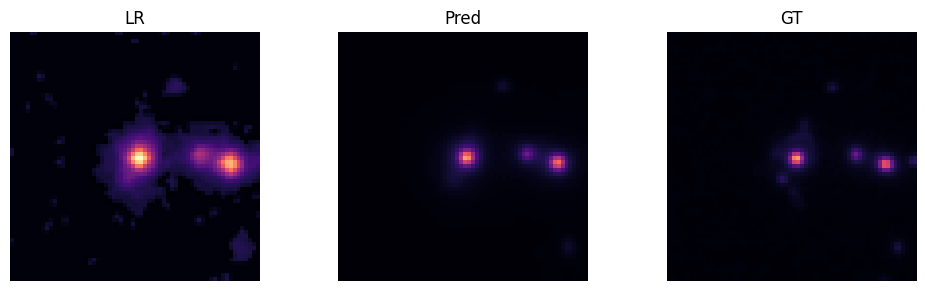

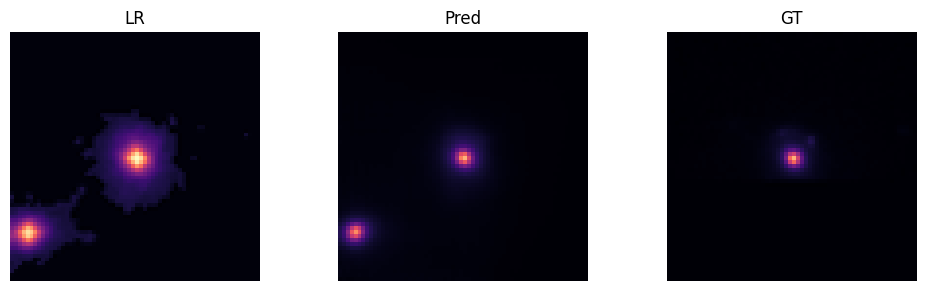

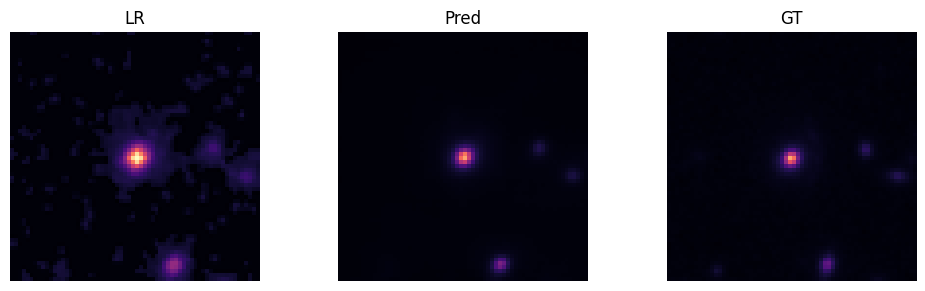

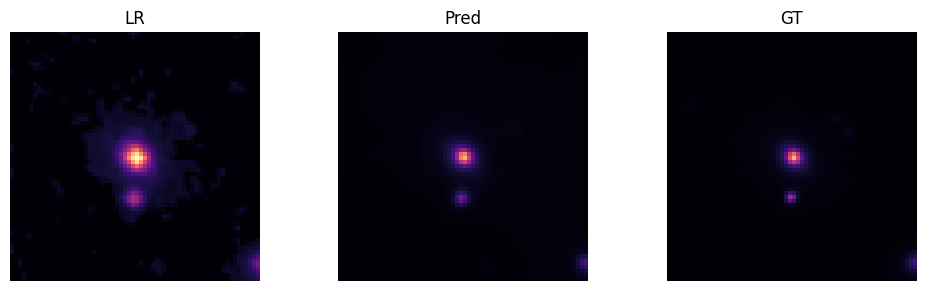

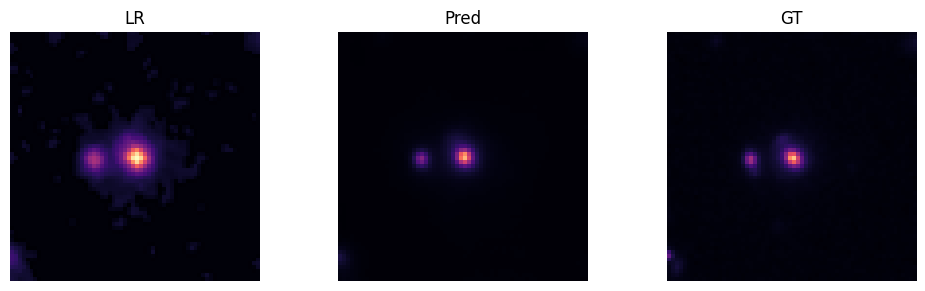

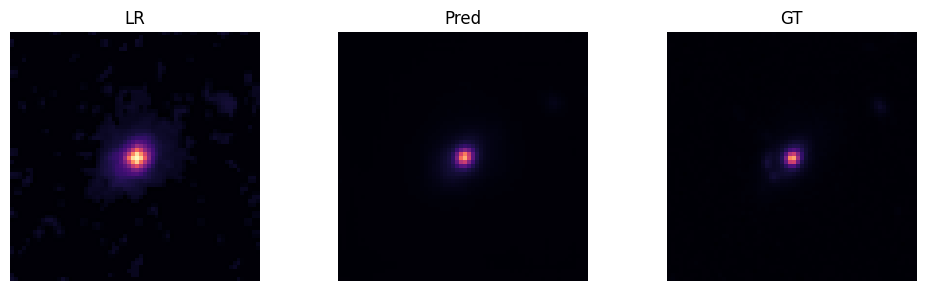

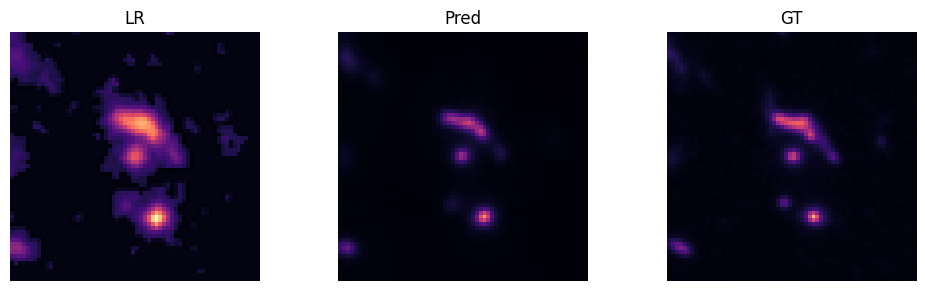

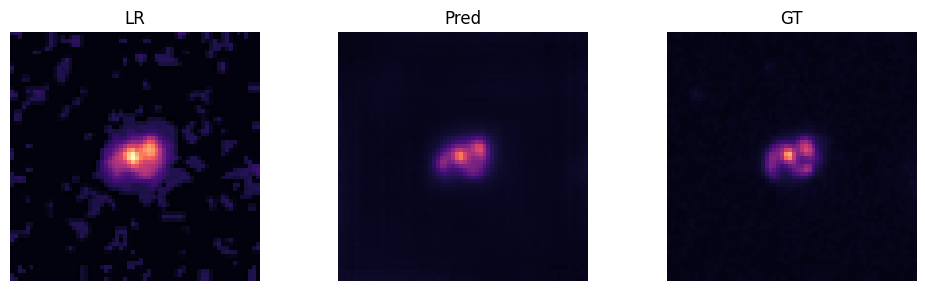

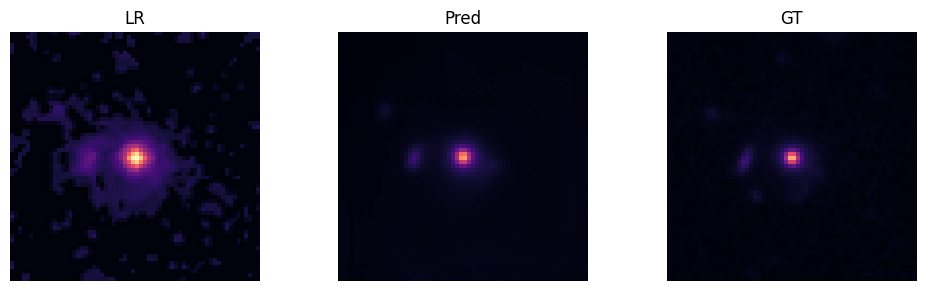

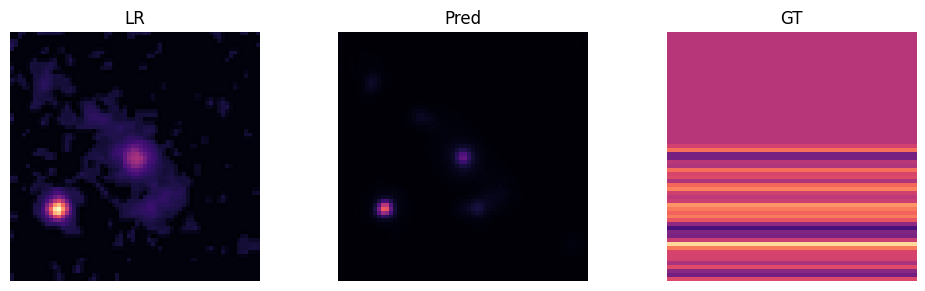

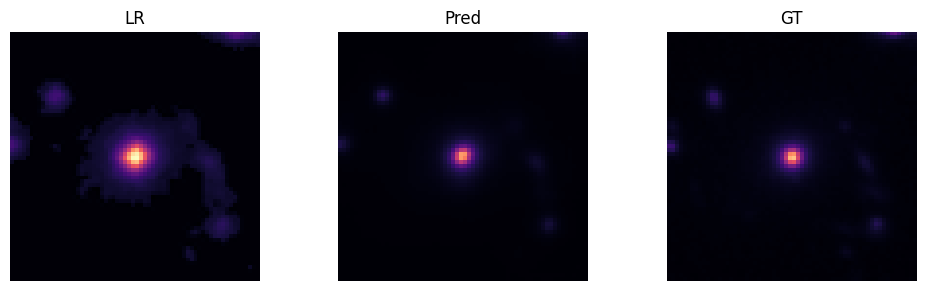

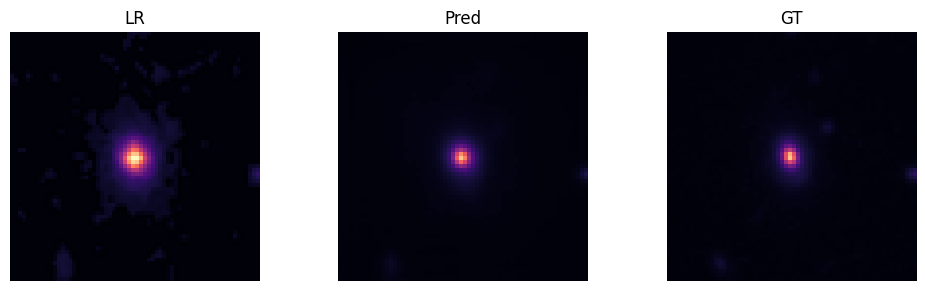

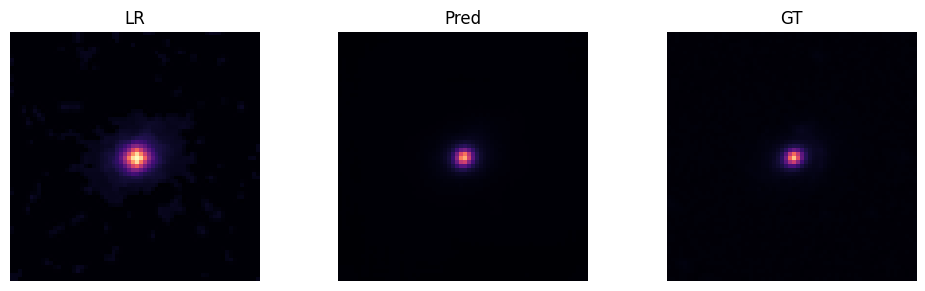

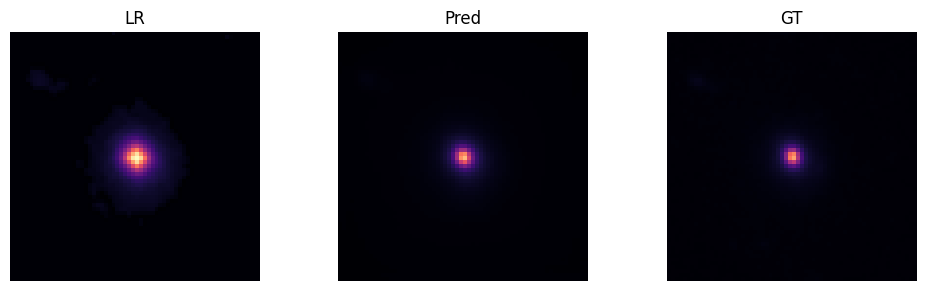

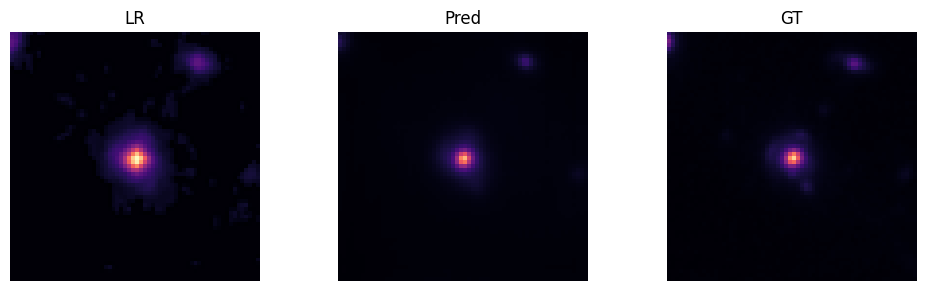

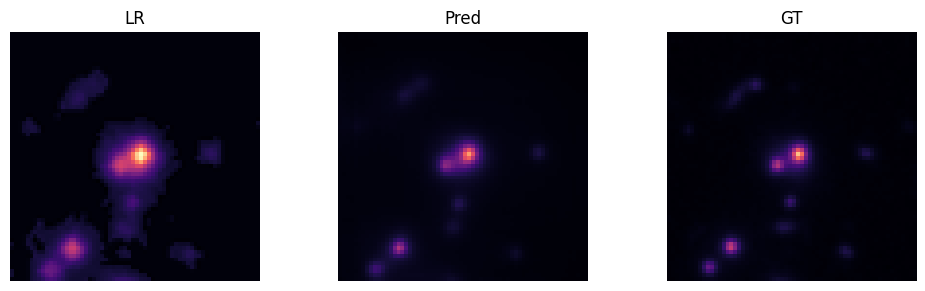

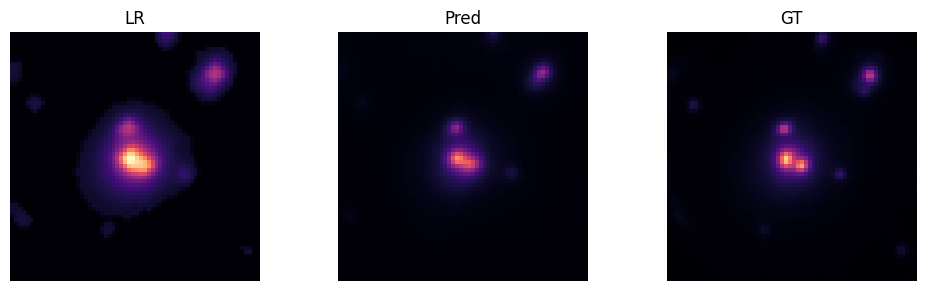

In [11]:
show_samples(model, val_loader_swin, n=40, vmax_lr=1, vmax_hr = 1)